In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import SimpleITK as sitk
import mahotas as mt
import imageio

from PIL import Image
from matplotlib.patches import Rectangle
from scipy import linalg
from skimage.util.shape import view_as_windows
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
from skimage.feature.texture import greycomatrix
from collageradiomics import Collage, HaralickFeature, show_colored_image, InformationMeasureOfCorrelation1Interpretation, scale_array_for_image, highlight_rectangle_on_image
from datetime import datetime

In [2]:
# Read image.
img_s = sitk.ReadImage('../../sample_data/ImageSlice.png')
img_array = sitk.GetArrayFromImage(img_s)

In [3]:
# Create window.
svd_radius = 5
patch_window_width = 30
patch_window_height = 30
mask_min_x = 252
mask_min_y = 193
mask_max_x = mask_min_x + patch_window_width
mask_max_y = mask_min_y + patch_window_height

In [4]:
# AngularSecondMoment
# Contrast
# Correlation
# SumOfSquareVariance
# SumAverage
# SumVariance
# SumEntropy
# Entropy
# DifferenceVariance
# DifferenceEntropy
# InformationMeasureOfCorrelation1
# InformationMeasureOfCorrelation2
# MaximalCorrelationCoefficient
# All
collage = Collage.from_rectangle(
    img_array, 
    mask_min_x, 
    mask_min_y, 
    patch_window_width, 
    patch_window_height, 
    svd_radius, 
    verbose_logging=True,
    haralick_feature_list=[HaralickFeature.SumOfSquareVariance]
)

In [5]:
# Run CoLlage Algorithm.
collage.execute()

IMAGE:
width=440 height=596
Cropped Array Shape: (30, 30)
x = 247:287 (40)
y = 188:228 (40)
PaddedCropped Array Shape: (40, 40)
dx shape = (40, 40)
dominant angles shape = (30, 30)
svd radius = 5
svd diameter = 11
dx windows shape = (30, 30, 11, 11)
Center x: range(0, 30), Center y: range(0, 30)
x=4, y=13
angle=1.3744220361262742
Done calculating dominant angles.
Calculating feature 4:
Calculated feature 4.


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [6]:
import logging
logger = logging.getLogger('imageio').setLevel(logging.ERROR)

def scale_array_for_image(array_to_scale):
    flat_array = array_to_scale.flatten()
    minimum = float(min(flat_array))
    maximum = float(max(flat_array))
    array_range = maximum - minimum
    array_to_scale = array_to_scale - minimum
    array_to_scale /= array_range
    array_to_scale *= 255
    return array_to_scale

def write_collage_image(feature, directory):
    collage_array = scale_array_for_image(collage.haralick_features[:,:,feature])
    collage_array = collage_array.astype('uint8')
    imageio.imwrite(f'{directory}/collage-feature-{feature + 1}.png', plt.cm.jet(collage_array))
    img = Image.open(f'{directory}/collage-feature-{feature + 1}.png')
    img = img.convert('RGBA')
    pixdata = img.load()

    width, height = img.size
    for y in range(height):
        for x in range(width):
            if pixdata[x, y] == (0, 0, 127, 255) or pixdata[x, y] == (127, 0, 0, 255):
                pixdata[x, y] = (255, 255, 255, 0)

    img.save(f'{directory}/collage-feature-{feature + 1}.png', 'PNG')
    background = Image.open('../../sample_data/ImageSlice.png')
    foreground = Image.open(f'{directory}/collage-feature-{feature + 1}.png')

    background = background.convert('RGBA')
    background.paste(foreground, (collage.mask_min_x, collage.mask_min_y), foreground)
    background.show()
    background.save(f'{directory}/collage-feature-{feature + 1}.png')

Original Image


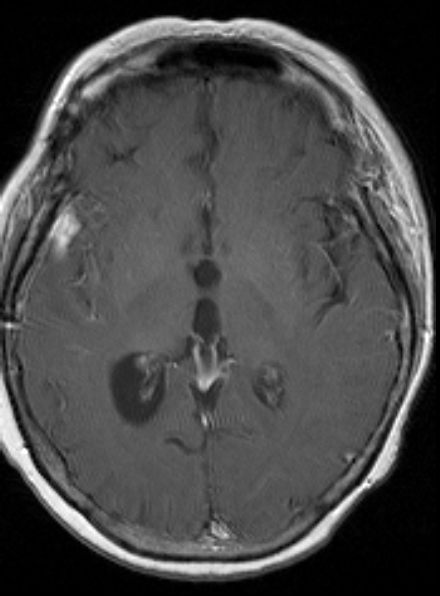

collage Feature 4


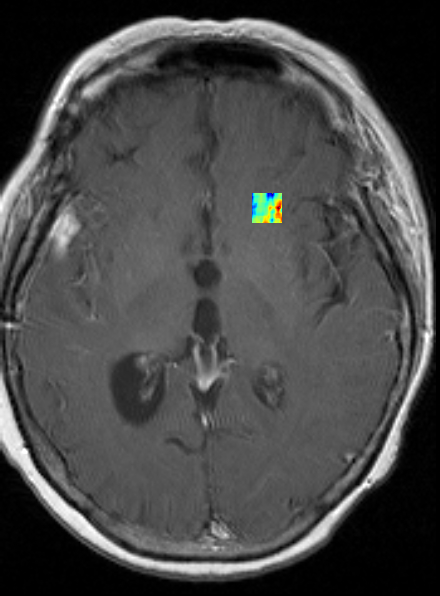

In [8]:
import pathlib

# Writes images to output_data directory in the root of the repository and show them.
print('Original Image')
display(Image.open('../../sample_data/ImageSlice.png'))

now = datetime.now()
date_string = now.strftime("%m%d%Y-%H%M%S")
output_directory = f'../../output_data/{date_string}'

pathlib.Path(output_directory).mkdir(parents=True, exist_ok=True) 

feature = 3
write_collage_image(feature, output_directory)
print(f'collage Feature {feature + 1}')
display(Image.open(f'{output_directory}/collage-feature-{feature + 1}.png'))